In [3]:
import numpy as np
import pandas as pd
from scipy.stats import norm
import statsmodels.api as sm
import matplotlib.pyplot as plt
from datetime import datetime
import requests
from io import BytesIO

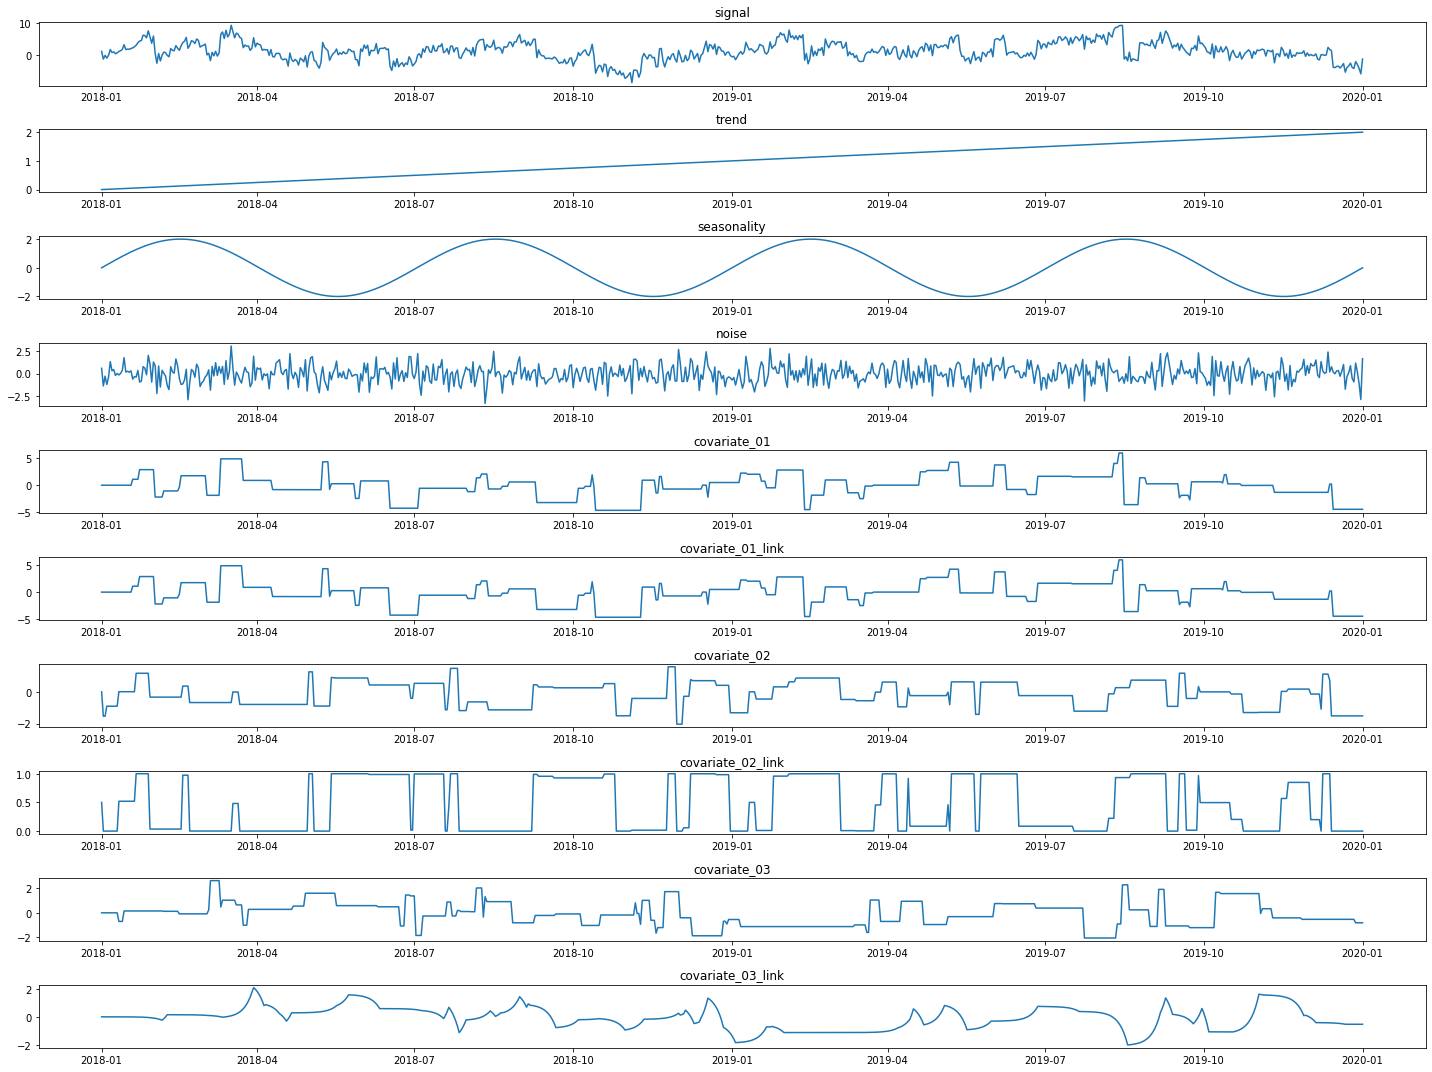

In [4]:
import numpy as np
import pandas as pd
import datetime
import collections
from matplotlib import pylab as plt
import seaborn as sns
import matplotlib.dates as mdates
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()
pd.options.mode.chained_assignment = None

from pdpbox import pdp
import lightgbm
import xgboost as xgb
import shap
shap.initjs()
    
def step_series(n, mean, scale, n_steps):
    s = np.zeros(n)
    step_idx = np.random.randint(0, n, n_steps)
    value = mean
    for t in range(n):
        s[t] = value
        if t in step_idx:
            value = mean + scale * np.random.randn()
    return s

def linear_link(x): 
    return x

def sigmoid_link(x, scale = 10):
    return 1 / (1 + np.exp(-scale*x))

def mem_link(x, length = 50):
    mfilter = np.exp(np.linspace(-10, 0, length))
    return np.convolve(x, mfilter/np.sum(mfilter), mode='same')

def create_signal(links = [linear_link, sigmoid_link, mem_link]):
    days_year = 365
    quaters_year = 4
    days_week = 7
    
    # two years of data, daily resolution
    idx = pd.date_range(start='2018-01-01', end='2020-01-01', freq='D') 

    df = pd.DataFrame(index=idx, dtype=float)
    df = df.fillna(0.0)
    
    n = len(df.index)
    trend = np.zeros(n)
    seasonality = np.zeros(n)
    for t in range(n):
        trend[t] = 2.0 * t/n
        seasonality[t] = 2.0 * np.sin(np.pi * t/days_year*quaters_year)
    
    covariates = [step_series(n, 0, 2.0, 80), step_series(n, 0, 1.0, 80), step_series(n, 0, 1.0, 80)]
    covariate_links = [ links[i](covariates[i]) for i in range(3) ]
    
    noise = np.random.randn(n)
    
    signal = trend + seasonality + np.sum(covariate_links, axis=0) + noise
    
    df['signal'], df['trend'], df['seasonality'], df['noise'] = signal, trend, seasonality, noise
    for i in range(3):
        df[f'covariate_0{i+1}'] = covariates[i]
        df[f'covariate_0{i+1}_link'] = covariate_links[i]
    
    return df

df = create_signal()
fig, ax = plt.subplots(len(df.columns), figsize=(20, 15))
for i, c in enumerate(df.columns):
    ax[i].plot(df.index, df[c])
    ax[i].set_title(c)

plt.tight_layout()
plt.show()

In [5]:
def step_series(n, mean, scale, n_steps):
    s = np.zeros(n)
    step_idx = np.random.randint(0, n, n_steps)
    value = mean
    for t in range(n):
        s[t] = value
        if t in step_idx:
            value = mean + scale * np.random.randn()
    return s

<AxesSubplot:>

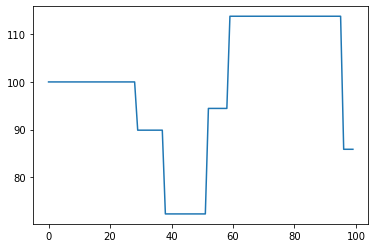

In [6]:
a=step_series(100,100,20,5) #step funkciju koristi za kreiranje kovarijata
a=pd.Series(a)
a.plot()

In [7]:
# engineer features for the model
#
def features_regression(df):       
    observed_features = ['covariate_01', 'covariate_02', 'covariate_03']    
    dff = df[['signal'] + observed_features]
    
    dff['year'] = dff.index.year
    dff['month'] = dff.index.month
    dff['day_of_year'] = dff.index.dayofyear

    feature_lags = [7, 14, 21, 28, 35, 42, 49, 120, 182, 365]
    for lag in feature_lags:
        dff.loc[:, f'signal_lag_{lag}'] = dff['signal'].shift(periods=lag, fill_value=0).values
        
    return dff

In [8]:
features_regression(df)

,signal,covariate_01,covariate_02,covariate_03,year,month,day_of_year,signal_lag_7,signal_lag_14,signal_lag_21,signal_lag_28,signal_lag_35,signal_lag_42,signal_lag_49,signal_lag_120,signal_lag_182,signal_lag_365
2018-01-01,1.092251,0.000000,0.000000,0.000000,2018,1,1,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2018-01-02,-1.298991,0.000000,-1.531009,0.000000,2018,1,2,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2018-01-03,-0.144744,0.000000,-1.531009,0.000000,2018,1,3,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2018-01-04,-0.988193,0.000000,-0.900893,0.000000,2018,1,4,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2018-01-05,-0.110928,0.000000,-0.900893,0.000000,2018,1,5,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-12-28,-2.063828,-4.413242,-1.509361,-0.815049,2019,12,362,-2.682930,1.325906,-1.553143,0.624401,-0.382809,1.513712,0.967793,2.951857,1.878136,-0.099377
2019-12-29,-2.990544,-4.413242,-1.509361,-0.815049,2019,12,363,-5.383397,-3.834042,0.071785,-0.251148,0.696705,-0.305076,1.476716,2.859069,3.349573,0.798847
2019-12-30,-4.207190,-4.413242,-1.509361,-0.815049,2019,12,364,-3.908017,-3.975089,0.063380,0.132727,0.467299,0.499376,-2.462521,4.708043,3.337359,0.920427
2019-12-31,-5.895895,-4.413242,-1.509361,-0.815049,2019,12,365,-3.431165,-3.596811,-0.139534,-0.175184,0.603878,-1.047383,0.235005,3.163040,2.239381,-0.230469


In [9]:
# train-test split
#
def split_train_test(df, train_ratio):    
    y_train, y_test = [], []
    x_train, x_test = [], []
    split_t = int(len(df)*train_ratio)
    
    y = df['signal']
    y_train = y[:split_t]
    y_test = y[split_t:]
            
    xdf = df.drop('signal', inplace=False, axis=1)
    x_train = xdf[:split_t]
    x_test = xdf[split_t:]
    
    return x_train, y_train, x_test, y_test

In [10]:
# fit LightGBM model
#
def fit_lightgbm(x_train, y_train, x_test, y_test, n_estimators=100):
     
    model = lightgbm.LGBMRegressor(
        boosting_type = 'gbdt',
        n_estimators=n_estimators)
    
    model.fit(x_train, 
              y_train, 
              eval_set=[(x_train, y_train), (x_test, y_test)], 
              eval_metric='mape')
    
    return model

[1]	training's mape: 0.836771	training's l2: 9.68207	valid_1's mape: 0.882658	valid_1's l2: 17.7573
[2]	training's mape: 0.765949	training's l2: 8.15649	valid_1's mape: 0.868282	valid_1's l2: 15.9467
[3]	training's mape: 0.7067	training's l2: 6.91091	valid_1's mape: 0.853642	valid_1's l2: 14.3407
[4]	training's mape: 0.650585	training's l2: 5.84224	valid_1's mape: 0.838379	valid_1's l2: 13.1624
[5]	training's mape: 0.601432	training's l2: 4.97418	valid_1's mape: 0.826199	valid_1's l2: 12.106
[6]	training's mape: 0.556776	training's l2: 4.26677	valid_1's mape: 0.816133	valid_1's l2: 11.7664
[7]	training's mape: 0.524006	training's l2: 3.6977	valid_1's mape: 0.812672	valid_1's l2: 11.2754
[8]	training's mape: 0.494108	training's l2: 3.218	valid_1's mape: 0.808723	valid_1's l2: 10.8523
[9]	training's mape: 0.468622	training's l2: 2.82102	valid_1's mape: 0.801847	valid_1's l2: 10.4733
[10]	training's mape: 0.447474	training's l2: 2.49271	valid_1's mape: 0.80287	valid_1's l2: 10.1982
[11]	t

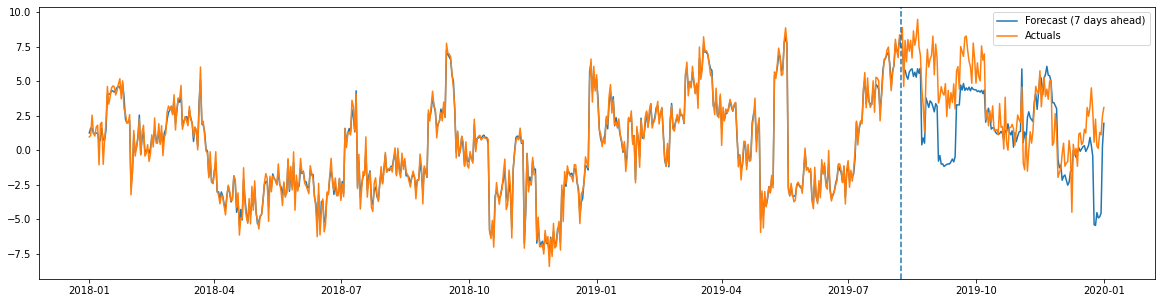

In [11]:
# generate data sample and fit the model
#
df = features_regression(create_signal(links = [linear_link, linear_link, mem_link]))
train_ratio = 0.8
x_train, y_train, x_test, y_test = split_train_test(df, train_ratio)
model = fit_lightgbm(x_train, y_train, x_test, y_test)    

#
# plot the forecast
#
forecast = model.predict(pd.concat([x_train, x_test]))
fig, ax = plt.subplots(1, figsize=(20, 5))
ax.plot(df.index, forecast, label='Forecast (7 days ahead)')
ax.plot(df.index, df['signal'], label='Actuals')
ax.axvline(x=df.index[int(len(df) * train_ratio)], linestyle='--')
ax.legend()

[1]	training's mape: 0.767079	training's l2: 5.43771	valid_1's mape: 0.736995	valid_1's l2: 4.9991
[2]	training's mape: 0.718697	training's l2: 4.68844	valid_1's mape: 0.678205	valid_1's l2: 4.5491
[3]	training's mape: 0.678211	training's l2: 4.09918	valid_1's mape: 0.677167	valid_1's l2: 4.28384
[4]	training's mape: 0.638929	training's l2: 3.57629	valid_1's mape: 0.64287	valid_1's l2: 4.02679
[5]	training's mape: 0.608031	training's l2: 3.17997	valid_1's mape: 0.651839	valid_1's l2: 3.96222
[6]	training's mape: 0.574872	training's l2: 2.82356	valid_1's mape: 0.642017	valid_1's l2: 3.90676
[7]	training's mape: 0.547941	training's l2: 2.51471	valid_1's mape: 0.637401	valid_1's l2: 3.82406
[8]	training's mape: 0.527864	training's l2: 2.26274	valid_1's mape: 0.649787	valid_1's l2: 3.84678
[9]	training's mape: 0.506657	training's l2: 2.0497	valid_1's mape: 0.66	valid_1's l2: 3.94733
[10]	training's mape: 0.489099	training's l2: 1.86865	valid_1's mape: 0.664482	valid_1's l2: 3.9376
[11]	tra

[25]	training's mape: 0.383578	training's quantile: 0.344841	valid_1's mape: 0.849098	valid_1's quantile: 0.67457
[26]	training's mape: 0.379219	training's quantile: 0.339514	valid_1's mape: 0.84194	valid_1's quantile: 0.670628
[27]	training's mape: 0.373912	training's quantile: 0.33245	valid_1's mape: 0.837416	valid_1's quantile: 0.66694
[28]	training's mape: 0.369792	training's quantile: 0.327116	valid_1's mape: 0.827599	valid_1's quantile: 0.66156
[29]	training's mape: 0.363604	training's quantile: 0.320476	valid_1's mape: 0.819448	valid_1's quantile: 0.654211
[30]	training's mape: 0.358247	training's quantile: 0.313858	valid_1's mape: 0.81228	valid_1's quantile: 0.644612
[31]	training's mape: 0.3539	training's quantile: 0.309609	valid_1's mape: 0.807826	valid_1's quantile: 0.639285
[32]	training's mape: 0.349298	training's quantile: 0.304221	valid_1's mape: 0.807414	valid_1's quantile: 0.636048
[33]	training's mape: 0.344617	training's quantile: 0.298156	valid_1's mape: 0.802611	va

[56]	training's mape: 0.901301	training's quantile: 0.151861	valid_1's mape: 1.1101	valid_1's quantile: 0.44808
[57]	training's mape: 0.896383	training's quantile: 0.150882	valid_1's mape: 1.10601	valid_1's quantile: 0.453201
[58]	training's mape: 0.889466	training's quantile: 0.149577	valid_1's mape: 1.09648	valid_1's quantile: 0.459061
[59]	training's mape: 0.883136	training's quantile: 0.148557	valid_1's mape: 1.09525	valid_1's quantile: 0.461024
[60]	training's mape: 0.878831	training's quantile: 0.147516	valid_1's mape: 1.08738	valid_1's quantile: 0.461272
[61]	training's mape: 0.873296	training's quantile: 0.146524	valid_1's mape: 1.07906	valid_1's quantile: 0.4601
[62]	training's mape: 0.867041	training's quantile: 0.145714	valid_1's mape: 1.07374	valid_1's quantile: 0.46321
[63]	training's mape: 0.857171	training's quantile: 0.143505	valid_1's mape: 1.05973	valid_1's quantile: 0.463212
[64]	training's mape: 0.853626	training's quantile: 0.14303	valid_1's mape: 1.05904	valid_1's

[28]	training's mape: 0.434475	training's quantile: 0.352076	valid_1's mape: 0.712371	valid_1's quantile: 0.781986
[29]	training's mape: 0.429418	training's quantile: 0.347307	valid_1's mape: 0.709658	valid_1's quantile: 0.779433
[30]	training's mape: 0.423706	training's quantile: 0.342155	valid_1's mape: 0.710395	valid_1's quantile: 0.77869
[31]	training's mape: 0.417829	training's quantile: 0.336774	valid_1's mape: 0.703825	valid_1's quantile: 0.775103
[32]	training's mape: 0.414559	training's quantile: 0.332515	valid_1's mape: 0.703789	valid_1's quantile: 0.773997
[33]	training's mape: 0.41088	training's quantile: 0.328465	valid_1's mape: 0.701776	valid_1's quantile: 0.773678
[34]	training's mape: 0.406821	training's quantile: 0.324782	valid_1's mape: 0.702396	valid_1's quantile: 0.775116
[35]	training's mape: 0.402877	training's quantile: 0.321747	valid_1's mape: 0.70205	valid_1's quantile: 0.774611
[36]	training's mape: 0.399647	training's quantile: 0.318766	valid_1's mape: 0.7014

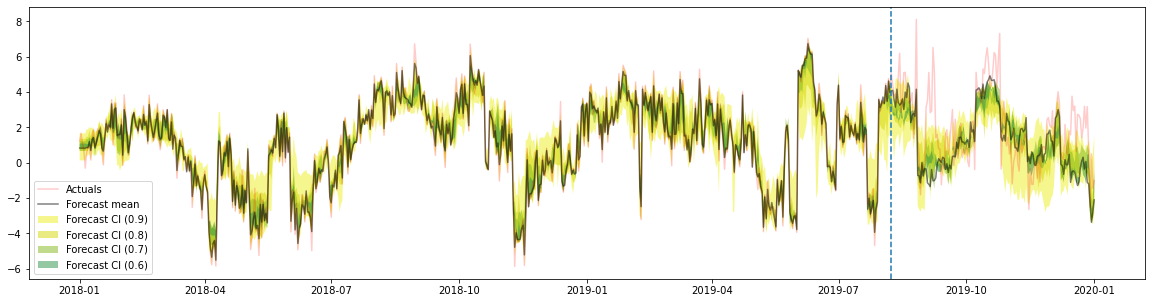

In [12]:
#Ubacujemo intervale poverenja kroz kvintilnu regresiju

#
# fit the quantile regression model with LightGBM
#
def fit_lightgbm_quantile(x_train, y_train, x_test, y_test, alpha, n_estimators=100):
     
    model = lightgbm.LGBMRegressor(
        boosting_type = 'gbdt',
        objective = 'quantile',        # sve je isto samo se ovaj parametar menja quantile loss function
        alpha = alpha,
        n_estimators=n_estimators)
    
    model.fit(x_train, 
              y_train, 
              eval_set=[(x_train, y_train), (x_test, y_test)], 
              eval_metric='mape')
    
    return model

#
# generate data sample and fit models
#
df = features_regression(create_signal(links = [linear_link, linear_link, mem_link]))
train_ratio = 0.8
x_train, y_train, x_test, y_test = split_train_test(df, train_ratio)
alphas = [0.90, 0.80, 0.70, 0.60] #intervali poverenja za kvintilnu regresiju
model_mean = fit_lightgbm(x_train, y_train, x_test, y_test)   
models_upper = [fit_lightgbm_quantile(x_train, y_train, x_test, y_test, 1 - alpha) 
                for alpha in alphas]
models_lower = [fit_lightgbm_quantile(x_train, y_train, x_test, y_test, alpha) 
                for alpha in alphas]

#
# plot the forecasts
#
x = pd.concat([x_train, x_test])
forecasts_upper = [model.predict(x) for model in models_upper]
forecasts_lower = [model.predict(x) for model in models_lower]
forecast_mean = model_mean.predict(x)

fig, ax = plt.subplots(1, figsize=(20, 5))
pal = ["#eeef20", "#d4d700", "#80b918", "#2b9348"]
for i, alpha in enumerate(alphas):
    ax.fill_between(df.index, forecasts_lower[i], forecasts_upper[i], alpha=0.5, fc=pal[i], ec='None', label=f'Forecast CI ({alpha})')
ax.plot(df.index, df['signal'], color='r', alpha=0.2, label='Actuals')
ax.plot(df.index, forecast_mean, color='k', alpha=0.5, label='Forecast mean')
ax.axvline(x=df.index[int(len(df) * train_ratio)], linestyle='--')
ax.legend()
plt.show()

In [13]:
pip install ngboost

Note: you may need to restart the kernel to use updated packages.


[iter 0] loss=2.3433 val_loss=0.0000 scale=1.0000 norm=2.1281
[iter 100] loss=1.9212 val_loss=0.0000 scale=1.0000 norm=1.4175
[iter 200] loss=1.6040 val_loss=0.0000 scale=1.0000 norm=1.0969
[iter 300] loss=1.3941 val_loss=0.0000 scale=1.0000 norm=0.9666
[iter 400] loss=1.2880 val_loss=0.0000 scale=1.0000 norm=0.9168


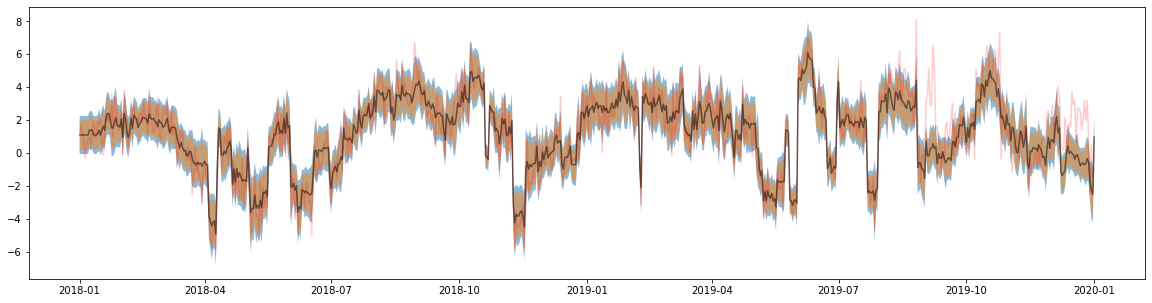

In [14]:
#Ova modifikacija radi tako što na predviđenim vrednostima crta normalnu distribucijju rasipanja
#odnosno intervale poverenja
from ngboost import NGBRegressor
from scipy.stats import norm

ngb = NGBRegressor().fit(x_train, y_train)   # Normal distribution by default
y_preds = ngb.predict(x)
y_dists = ngb.pred_dist(x)

fig, ax = plt.subplots(1, figsize=(20, 5))
alphas = [0.95, 0.90]
for i, alpha in enumerate(alphas):
    rng = norm(loc=0.0, scale=y_dists.params['scale']).ppf(alpha) 
    ax.fill_between(df.index, y_preds + rng, y_preds - rng, 
                    alpha=0.5, ec='None', label=f'Forecast CI ({alpha})')
ax.plot(df.index, df['signal'], color='r', alpha=0.2, label='Actuals')
ax.plot(df.index, y_preds, color='k', alpha=0.5, label='Forecast mean')

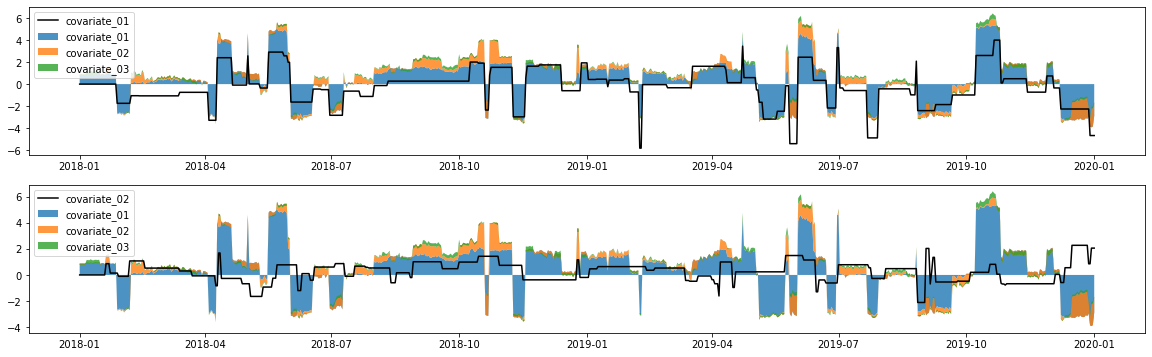

In [15]:
#Sledeći kod nastoji da otkrije doprinos svakog prediktora predviđanju a to radi
#tako što predviđanje sa svim prediktorima oduzme od predviđanja bez tog prediktora
import shap

series_to_explain = pd.concat([x_train, x_test])
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(series_to_explain)

feature_names=['covariate_01', 'covariate_02', 'covariate_03']
cols = [series_to_explain.columns.get_loc(c) for c in feature_names]
values = shap_values[:, cols]
fig, ax = plt.subplots(2, figsize=(20, 6))
for i in [0, 1]:
    ax[i].stackplot(series_to_explain.index, values.T, 
                    alpha=0.8, labels=feature_names)
    ax[i].plot(series_to_explain.index, series_to_explain[f'covariate_0{i+1}'], 
               color='k', label=f'covariate_0{i+1}')
    ax[i].legend()

[1]	training's mape: 0.803144	training's l2: 5.40879	valid_1's mape: 0.826185	valid_1's l2: 9.80124
[2]	training's mape: 0.748889	training's l2: 4.67074	valid_1's mape: 0.782994	valid_1's l2: 8.90125
[3]	training's mape: 0.702965	training's l2: 4.0352	valid_1's mape: 0.762361	valid_1's l2: 8.65665
[4]	training's mape: 0.659473	training's l2: 3.52596	valid_1's mape: 0.729446	valid_1's l2: 7.89086
[5]	training's mape: 0.623794	training's l2: 3.11958	valid_1's mape: 0.711721	valid_1's l2: 7.39796
[6]	training's mape: 0.591652	training's l2: 2.77558	valid_1's mape: 0.690399	valid_1's l2: 6.82372
[7]	training's mape: 0.564566	training's l2: 2.46908	valid_1's mape: 0.683857	valid_1's l2: 6.6667
[8]	training's mape: 0.539328	training's l2: 2.2111	valid_1's mape: 0.674373	valid_1's l2: 6.51032
[9]	training's mape: 0.521683	training's l2: 2.01249	valid_1's mape: 0.663296	valid_1's l2: 6.14754
[10]	training's mape: 0.505358	training's l2: 1.83959	valid_1's mape: 0.656216	valid_1's l2: 6.03779
[1

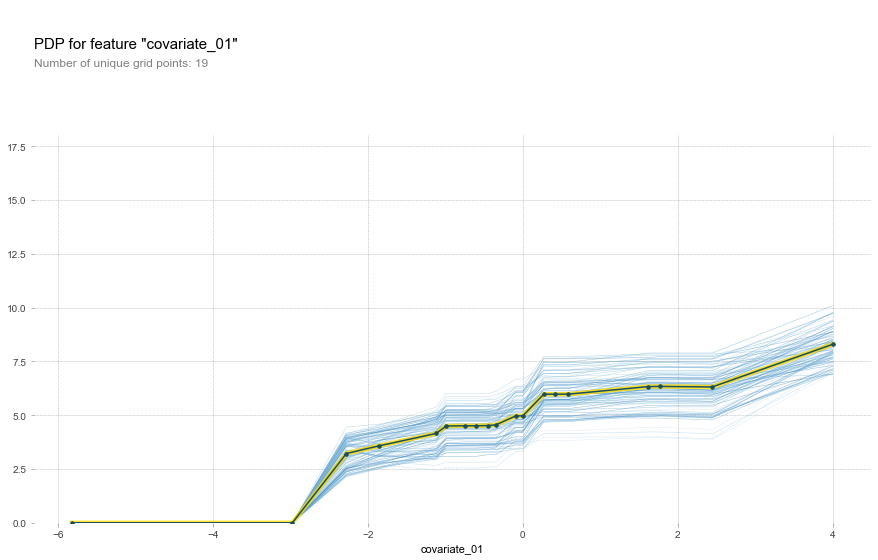

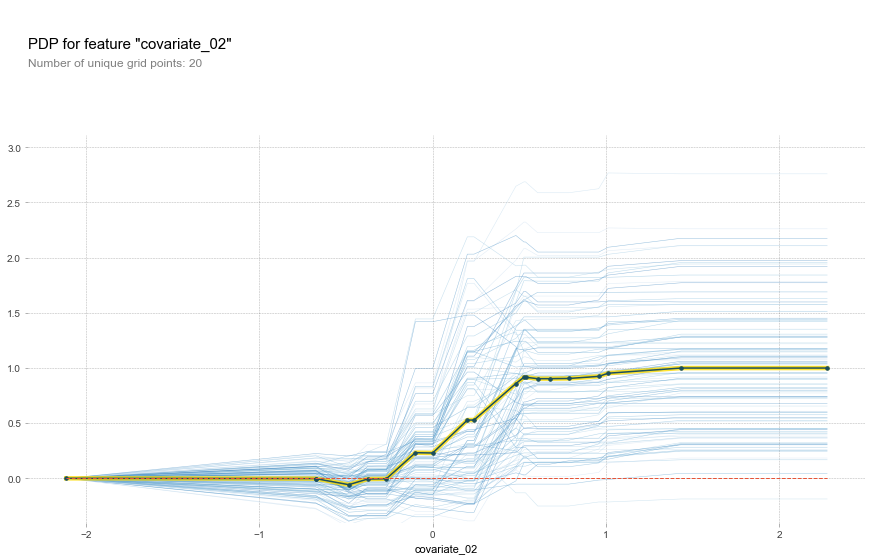

In [16]:
#Sledeći kod nastoji da prikaže oblik funkcije između kovarijata i signala
#ppd daje da je uticaj prvog kovarijata linearan a drugog sigmoidalan što se vidi
#prema grafikonima

from pdpbox import pdp

df = features_regression(create_signal(links = [linear_link, sigmoid_link, mem_link]))
train_ratio = 0.8
x_train, y_train, x_test, y_test = split_train_test(df, train_ratio)
model = fit_lightgbm(x_train, y_train, x_test, y_test)

for i in [1, 2]:
    pdp_isolate = pdp.pdp_isolate(
        model=model, 
        dataset=series_to_explain, 
        model_features=series_to_explain.columns, 
        feature=f'covariate_0{i}',
        num_grid_points=20)
    pdp.pdp_plot(pdp_isolate, f'covariate_0{i}', plot_lines=True, frac_to_plot=100)

In [17]:
#Lagged regresija u ovaj kod se nisam udubljivao
# prepare features for lagged regression
#
df_original = create_signal()
observed_features = ['covariate_01', 'covariate_02'] 
df = df_original[['signal'] + observed_features]
df['year'] = df.index.year
df['month'] = df.index.month
df['day_of_year'] = df.index.dayofyear
lags = np.arange(0, 50, 5)
for lag in lags:
    df.loc[:, f'covariate_03_lag_{lag}'] = 
    df_original['covariate_03'].shift(periods=lag, fill_value=0).values

#
# LightGBM
#
x_train, y_train, x_test, y_test = split_train_test(df, train_ratio)
model = fit_lightgbm(x_train, y_train, x_test, y_test)

#
# SHAP
#
series_to_explain = pd.concat([x_train, x_test])
patch_model(model)
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(series_to_explain)

#
# 
#
feature_names=[f'covariate_03_lag_{lag}' for lag in lags]
cols = [series_to_explain.columns.get_loc(c) for c in feature_names]
values = shap_values[:, cols]
fig, ax = plt.subplots(1, figsize=(20, 5))
ax.stackplot(series_to_explain.index, values.T, alpha=0.8)
ax.plot(series_to_explain.index, df_original['covariate_03_link'], 
        color='k', label='True covariate link')
plt.legend()
plt.show()

SyntaxError: invalid syntax (<ipython-input-17-41f9ad595320>, line 12)

In [18]:
import numpy as np
import pandas as pd
import datetime
import collections
from matplotlib import pylab as plt
plt.style.use('ggplot')
import seaborn as sns
import matplotlib.dates as mdates
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()
pd.options.mode.chained_assignment = None

import tensorflow as tf
from sklearn import preprocessing
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import LSTM, Dense, Input 
from tensorflow.keras.layers import Lambda, RepeatVector, Permute, Flatten, Activation, Multiply
from tensorflow.keras.constraints import NonNeg
from tensorflow.keras import backend as K

from tensorflow.keras.regularizers import l1
from tensorflow.keras.layers import LSTM
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

<AxesSubplot:>

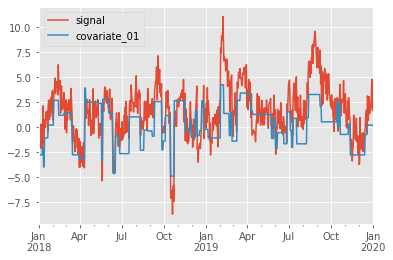

In [19]:
df[['signal', 'covariate_01']].plot()

In [20]:
#Primena LSTM, odnosno rekurentih neuralnih mreža na vremensku seriju
#
#
# engineer features and create input tensors
#

def normalize(df):
    x = df.values 
    min_max_scaler = preprocessing.MinMaxScaler()
    x_scaled = min_max_scaler.fit_transform(x)
    return pd.DataFrame(x_scaled, index=df.index, columns=df.columns)
    
def prepare_features_rnn(df):
    df_rnn = df[['signal', 'covariate_01', 'covariate_02']]
    df_rnn['year'] = df_rnn.index.year
    df_rnn['month'] = df_rnn.index.month
    df_rnn['day_of_year'] = df_rnn.index.dayofyear
    return normalize(df_rnn)
    
#
# train-test split and adjustments
#
def train_test_split(df, train_ratio, forecast_days_ahead, n_time_steps, time_step_interval): 

    # lenght of the input time window for each sample (the offset of the oldest sample in the input)
    input_window_size = n_time_steps*time_step_interval

    split_t = int(len(df)*train_ratio)
    x_train, y_train = [], []
    x_test, y_test = [], []
    y_col_idx = list(df.columns).index('signal')
    for i in range(input_window_size, len(df)):
        t_start = df.index[i - input_window_size]
        t_end = df.index[i]
        
        # we zero out last forecast_days_ahead signal observations, but covariates are assumed to be known
        x_t = df[t_start:t_end:time_step_interval].values.copy()
        if time_step_interval <= forecast_days_ahead:
            x_t[-int((forecast_days_ahead) / time_step_interval):, y_col_idx] = 0
        
        y_t = df.iloc[i]['signal']
            
        if i < split_t:
            x_train.append(x_t)
            y_train.append(y_t)
        else:
            x_test.append(x_t)
            y_test.append(y_t)       
    
    return np.stack(x_train), np.hstack(y_train), np.stack(x_test), np.hstack(y_test)

#
# parameters
#
n_time_steps = 40         # lenght of LSTM input in samples
time_step_interval = 2    # sampling interval, days
hidden_units = 8          # LSTM state dimensionality
forecast_days_ahead = 7
train_ratio = 0.8

#
# generate data and fit the model
#
df = create_signal()
df_rnn = prepare_features_rnn(df)
x_train, y_train, x_test, y_test = train_test_split(df_rnn, train_ratio, 
                                                    forecast_days_ahead, 
                                                    n_time_steps, time_step_interval)

print(f'Input tensor shape {x_train.shape}')

n_samples = x_train.shape[0]
n_features = x_train.shape[2]

input_model = Input(shape=(n_time_steps, n_features))
lstm_state_seq, state_h, state_c = LSTM(hidden_units, return_sequences=True, 
                                        return_state=True)(input_model)
output_dense = Dense(1)(state_c)
model_lstm = Model(inputs=input_model, outputs=output_dense)

tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)
model_lstm.compile(loss='mean_squared_error',  metrics=['mean_absolute_percentage_error'], 
                   optimizer='RMSprop')
model_lstm.summary()
model_lstm.fit(x_train, y_train, epochs=20, batch_size=4, validation_data=(x_test, y_test), use_multiprocessing=True, verbose=1)
score = model_lstm.evaluate(x_test, y_test, verbose=0) 
print('Test MSE:', score[0]) 
print('Test MAPE:', score[1])

Input tensor shape (504, 41, 6)
Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 40, 6)]           0         
_________________________________________________________________
lstm (LSTM)                  [(None, 40, 8), (None, 8) 480       
_________________________________________________________________
dense (Dense)                (None, 1)                 9         
Total params: 489
Trainable params: 489
Non-trainable params: 0
_________________________________________________________________
Epoch 1/20
126/126 [==============================] - 1s 10ms/step - loss: 0.0494 - mean_absolute_percentage_error: 756817.9375 - val_loss: 0.0194 - val_mean_absolute_percentage_error: 22.7481
Epoch 2/20
126/126 [==============================] - 1s 6ms/step - loss: 0.0246 - mean_absolute_percentage_error: 741808.0625 - val_loss: 0.0149 - val_mean_abso

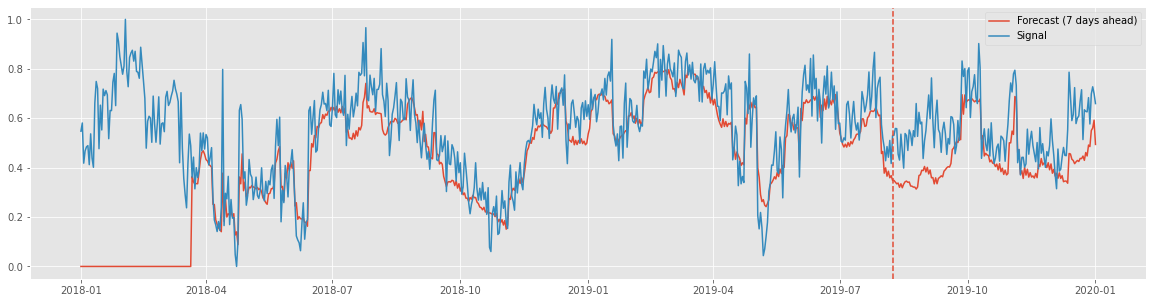

In [21]:
input_window_size = n_time_steps*time_step_interval
x = np.vstack([x_train, x_test])
y_hat = model_lstm.predict(x)
forecast = np.append(np.zeros(input_window_size), y_hat) 

#
# plot the forecast
#
fig, ax = plt.subplots(1, figsize=(20, 5))
ax.plot(df_rnn.index, forecast, label=f'Forecast ({forecast_days_ahead} days ahead)')
ax.plot(df_rnn.index, df_rnn['signal'], label='Signal')
ax.axvline(x=df.index[int(len(df) * train_ratio)], linestyle='--')
ax.legend()
plt.show()


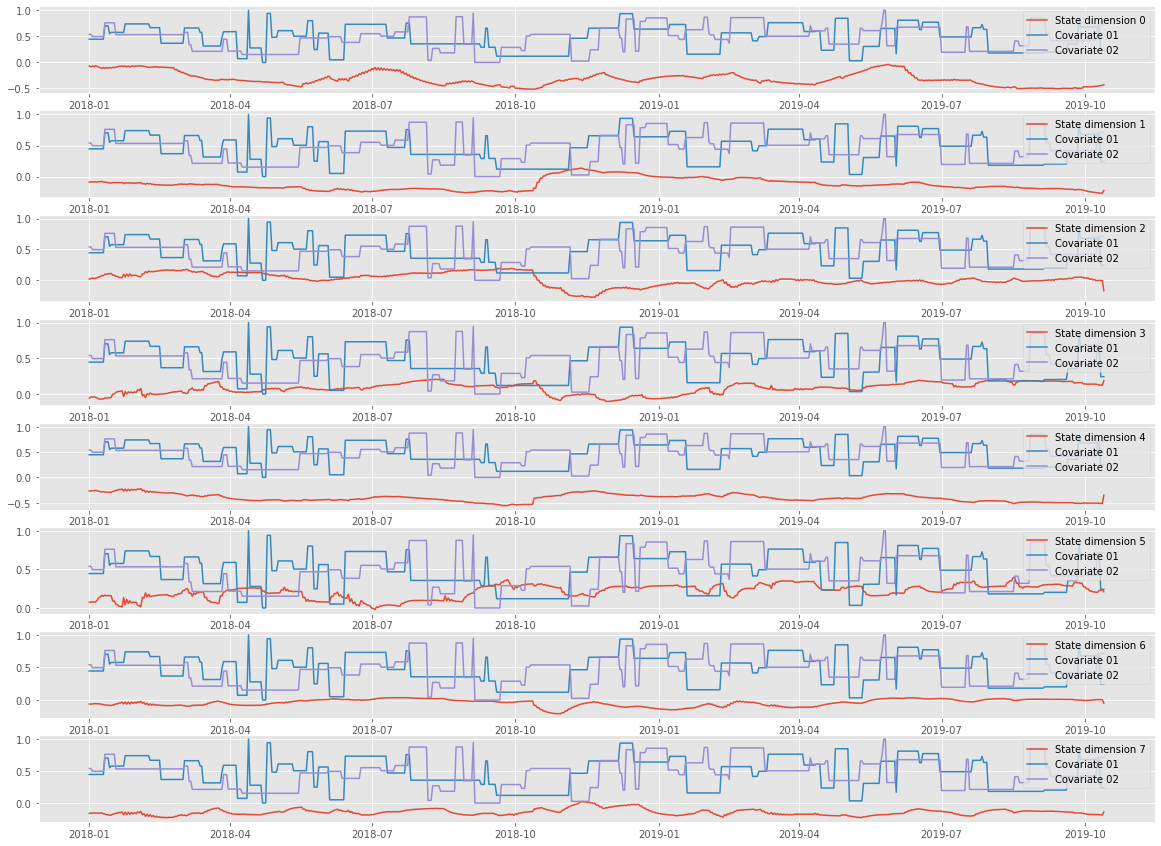

In [22]:
# plot the evolution of the LSTM state 
#
lstm_state_tap = Model(model_lstm.input, lstm_state_seq)
lstm_state_trace = lstm_state_tap.predict(x)

state_series = lstm_state_trace[:, -1, :].T
fig, ax = plt.subplots(len(state_series), figsize=(20, 15))
for i, state in enumerate(state_series):
    ax[i].plot(df_rnn.index[:len(state)], state, label=f'State dimension {i}')
    for j in [1, 2]:
        ax[i].plot(df_rnn.index[:len(state)], 
                   df_rnn[f'covariate_0{j}'][:len(state)], 
                   label=f'Covariate 0{j}')

    ax[i].legend(loc='upper right')
plt.show()

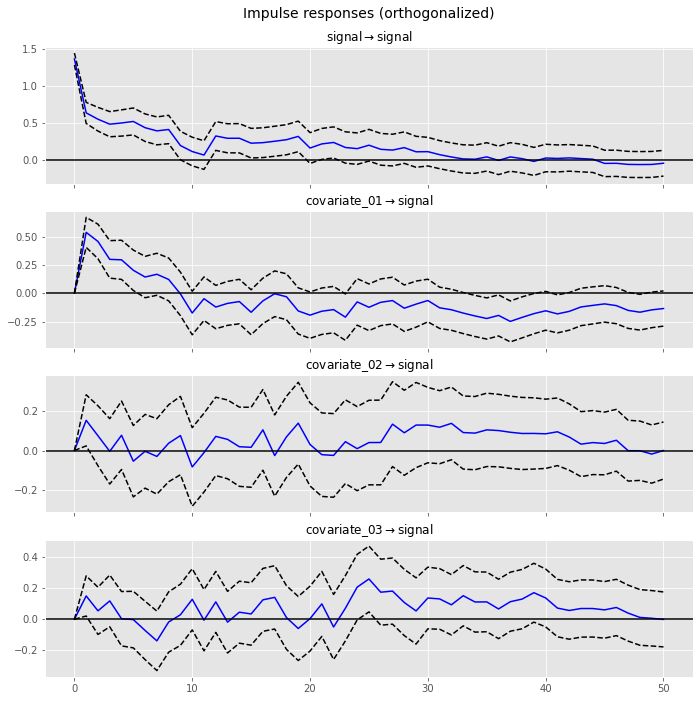

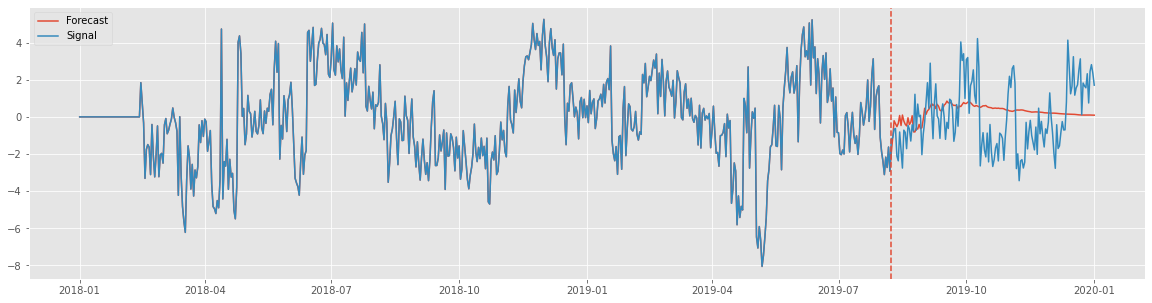

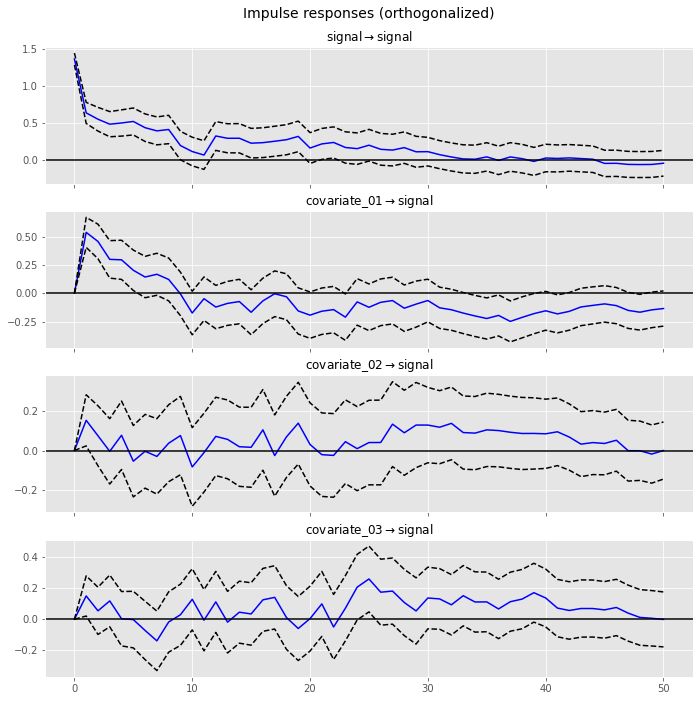

In [23]:
#vector autoregressive (VAR) model
#The VAR model considers the case of several interrelated time series. 
#We are interested in modeling a 𝑇×𝐾 multivariate time series 𝑌, where 𝑇 denotes the 
#number of observations and 𝐾 the number of variables. One way of estimating 
#relationships between the time series and their lagged values is 
#the vector autoregression process:
#𝑌𝑡=𝜈+𝐴1𝑌𝑡−1+…+𝐴𝑝𝑌𝑡−𝑝+𝑢𝑡𝑢𝑡∼𝖭𝗈𝗋𝗆𝖺𝗅(0,Σ𝑢)

# subtract the rolling mean to remove trend/seasonality
from statsmodels.tsa.api import VAR
df['signal'] = df['signal'] - df['signal'].rolling(int(len(df)/16)).mean()
df[np.isnan(df)] = 0

#
# fit the VAR model 
#
endog_cols = ['signal', 'covariate_01', 'covariate_02', 'covariate_03']  
df_endog = df[endog_cols]

split_t = int(len(df_endog) * 0.8)
idx_train, idx_test = df_endog.index[:split_t], df_endog.index[split_t:]
x_endog_train, x_endog_test = df_endog[:split_t], df_endog[split_t:]
model_var = VAR(endog = x_endog_train, dates = idx_train, freq = 'D') #MODEL
model_var_fitted = model_var.fit(30, trend='c') #PREDVIĐANJE BUDUĆIH 30 TAČAKA

forecast_steps = len(x_endog_test)
forecast = model_var_fitted.forecast(y=x_endog_train.values, steps=forecast_steps)

#
# visualize the results
#
fig, ax = plt.subplots(1, figsize=(20, 5))
y_test_pred = np.concatenate([x_endog_train.values, forecast])
df_forecast = df.copy()
df_forecast['forecast'] = y_test_pred[:, 0]
        
ax.plot(df_forecast['forecast'], label='Forecast')
ax.plot(df_forecast['signal'], label='Signal')
ax.axvline(x=df_forecast.index[len(x_endog_train)], linestyle='--')
ax.legend()

irf = model_var_fitted.irf(50) #Analyze impulse responses to shocks in system
    
irf.plot(orth=True, response='signal') 

In [ ]:
pip install fbprophet

In [25]:
df_endog

,signal,covariate_01,covariate_02,covariate_03
2018-01-01,0.000000,0.000000,0.000000,0.000000
2018-01-02,0.000000,0.000000,0.000000,0.000000
2018-01-03,0.000000,0.000000,-0.166182,-0.120326
2018-01-04,0.000000,0.000000,-0.166182,-0.120326
2018-01-05,0.000000,0.000000,-0.166182,-0.120326
...,...,...,...,...
2019-12-28,0.593179,-0.138180,-1.683931,0.269633
2019-12-29,2.205804,0.927022,-1.683931,0.269633
2019-12-30,2.484091,0.927022,-1.683931,0.269633
2019-12-31,1.966619,0.927022,-1.683931,0.269633


In [65]:
df_prophet =pd.DataFrame()

In [66]:
df_prophet['ds']=df_endog.index


,ds
0,2018-01-01
1,2018-01-02
2,2018-01-03
3,2018-01-04
4,2018-01-05
...,...
726,2019-12-28
727,2019-12-29
728,2019-12-30
729,2019-12-31


In [67]:
df_endog['ds']=df_endog.index

,signal,covariate_01,covariate_02,covariate_03,ds
2018-01-01,0.000000,0.000000,0.000000,0.000000,2018-01-01
2018-01-02,0.000000,0.000000,0.000000,0.000000,2018-01-02
2018-01-03,0.000000,0.000000,-0.166182,-0.120326,2018-01-03
2018-01-04,0.000000,0.000000,-0.166182,-0.120326,2018-01-04
2018-01-05,0.000000,0.000000,-0.166182,-0.120326,2018-01-05
...,...,...,...,...,...
2019-12-28,-1.368629,-0.138180,-1.683931,0.269633,2019-12-28
2019-12-29,0.122668,0.927022,-1.683931,0.269633,2019-12-29
2019-12-30,0.315128,0.927022,-1.683931,0.269633,2019-12-30
2019-12-31,-0.232745,0.927022,-1.683931,0.269633,2019-12-31


In [68]:
df_endog = pd.merge(df_prophet, df_endog["signal"], on=df_endog["ds"], how="left")

In [69]:
df_endog['y']=df_endog['signal']

In [74]:
df_endog=df_endog.drop(['signal', 'key_0'], axis=1)

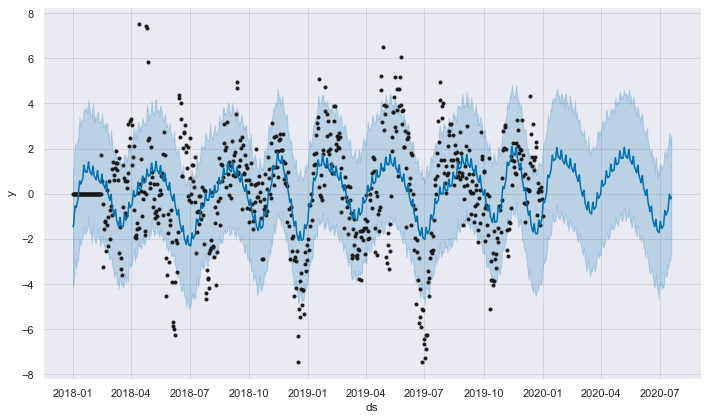

In [77]:
#Prophet može da učita samo kolone ds i y, datum i vrednost

from fbprophet import Prophet
sns.set(font_scale=1) 

m = Prophet(daily_seasonality=True)
m.fit(df_endog)
future = m.make_future_dataframe(periods=200,freq='D') #predviđanje za budućih 200 vremenskih tačaka
forecast = m.predict(future)
fig = m.plot(forecast)

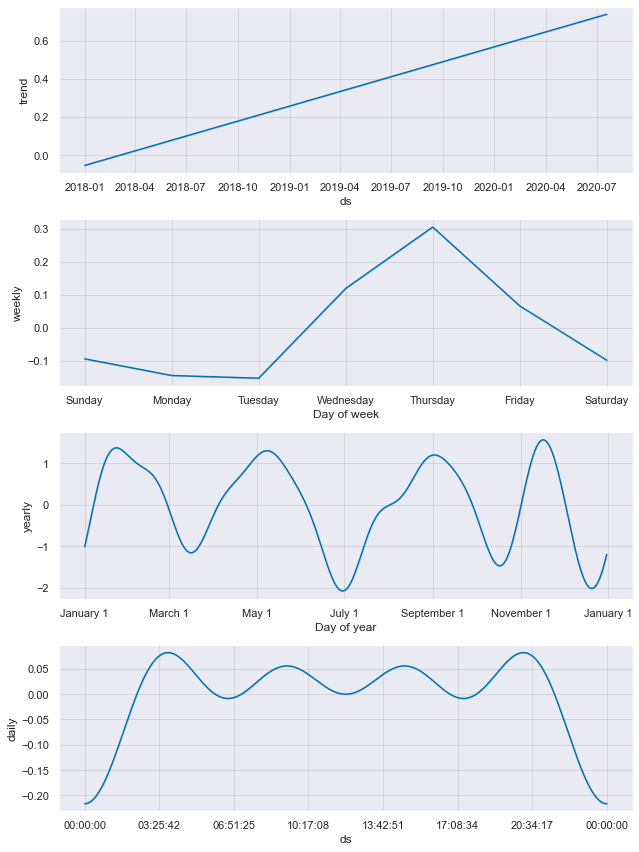

In [78]:
fig2 = m.plot_components(forecast)